In [34]:
from data_loader import load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.utils import resample

import warnings
warnings.filterwarnings(action="ignore")


# 1. Load the data from the `data_loader`:

In [2]:
df = load_data()
df.head(1)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


## 2. EDA:

## 2.1 Data dimension:

In [8]:
print(f"There are a total of: {df.shape[0]} samples and {df.shape[1]} features in this data.")

There are a total of: 7043 samples and 21 features in this data.


`customer_id` won't be relevant for us, so we will drop it now.

In [9]:
df = df.drop(columns=['customer_id'])

In [10]:
df.shape

(7043, 20)

## 2.2 Check for NULL values:

In [14]:
df.isna().sum()

gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

We don't have any missing values.

## 2.3 Data info:

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             7043 non-null   object
 1   senior_citizen     7043 non-null   int64 
 2   partner            7043 non-null   object
 3   dependents         7043 non-null   object
 4   tenure             7043 non-null   int64 
 5   phone_service      7043 non-null   object
 6   multiple_lines     7043 non-null   object
 7   internet_service   7043 non-null   object
 8   online_security    7043 non-null   object
 9   online_backup      7043 non-null   object
 10  device_protection  7043 non-null   object
 11  tech_support       7043 non-null   object
 12  streaming_tv       7043 non-null   object
 13  streaming_movies   7043 non-null   object
 14  contract           7043 non-null   object
 15  paperless_billing  7043 non-null   object
 16  payment_method     7043 non-null   object


There are some changes we need to do for the `dtypes`.

In [22]:
df['senior_citizen'] = df['senior_citizen'].astype('object')
df['monthly_charges'] = df['monthly_charges'].astype('float64')
df['total_charges'] = df['total_charges'].astype('float64')

In [24]:
df['churn'] = df['churn'].map({"Yes": 1, "No":0})

In [25]:
df.head(1)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0


## 2.4 Data Exploration with Visualization:

It is important to understand the data distribution and most importantly for a classification task i.e. whehter a customer will Churn `1` or Not-Churn `0`, we need to see if we have class imabalance or not. It is quite common to have a class imbalance problem, where the count of one class is higher than the other, which might create problem when building the model. It will create a bias.

### Univariate Analysis:

#### Churn:

In [28]:
df['churn'].value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

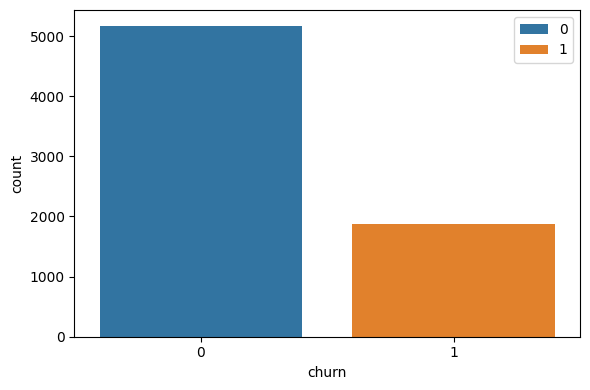

In [33]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='churn', hue='churn')
plt.legend()
plt.tight_layout()
plt.show()

The dataset is imbalanced, `class 0` is dominating the count.

When training the model in the later stage, I will use two versions of dataset:
1. This normal imbalanced dataset.
2. A balanced dataset which will be handled using `Oversampling technique`.

And then compare the results and choose the data accordingly but use of imbalanced data will most defnitely create the problem, so lets find out later on.

Now, i will use a resample technique and handle the class imbalance and keep this data set separately to try out at the later stage.

#### Handling class imbalance:

In [38]:
majority_class = df[df['churn'] == 0]
minorty_class = df[df['churn'] == 1]

minority_oversampled = resample(minorty_class, replace=True, n_samples=len(majority_class), random_state=42)
df_balanced = pd.concat([majority_class, minority_oversampled])

# To shuffle the data to introduce randomness:
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

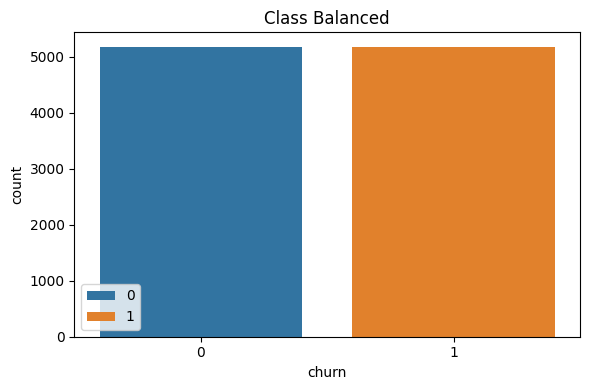

In [49]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_balanced, x='churn', hue='churn')
plt.title("Class Balanced")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [50]:
df_balanced.shape

(10348, 20)

Now, we have a balanced dataset.

#### Numerical Features:

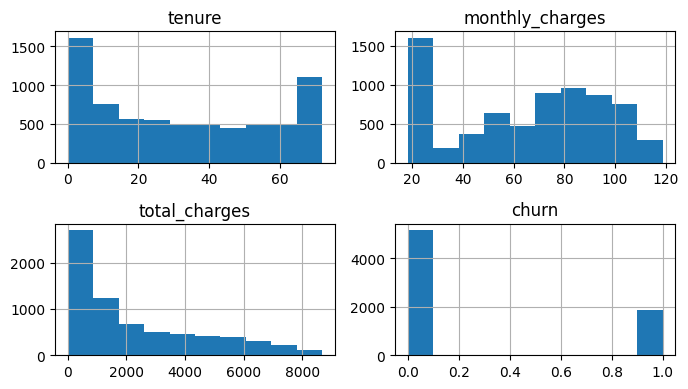

In [54]:
df.hist(figsize=(7, 4))
plt.tight_layout()
plt.show()

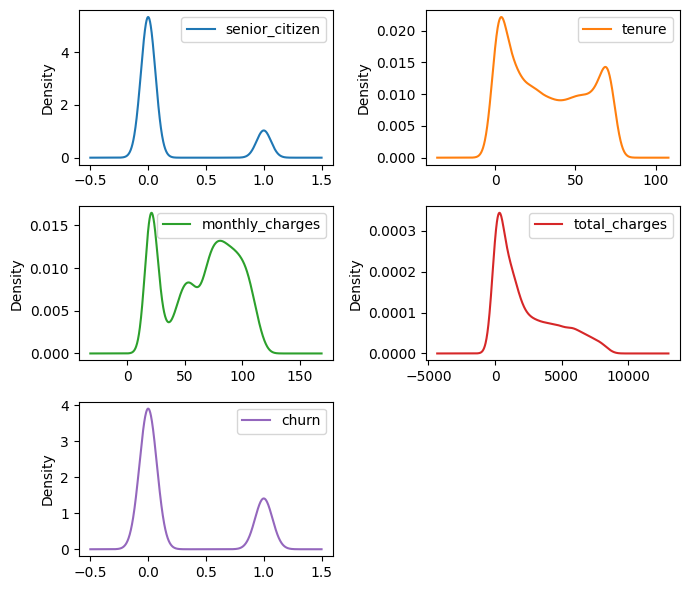

In [62]:
df.plot(kind='density', subplots=True, layout=(3, 2), figsize=(7, 6), sharex=False)
plt.tight_layout()
plt.show()

We can see that most of the clients are young.

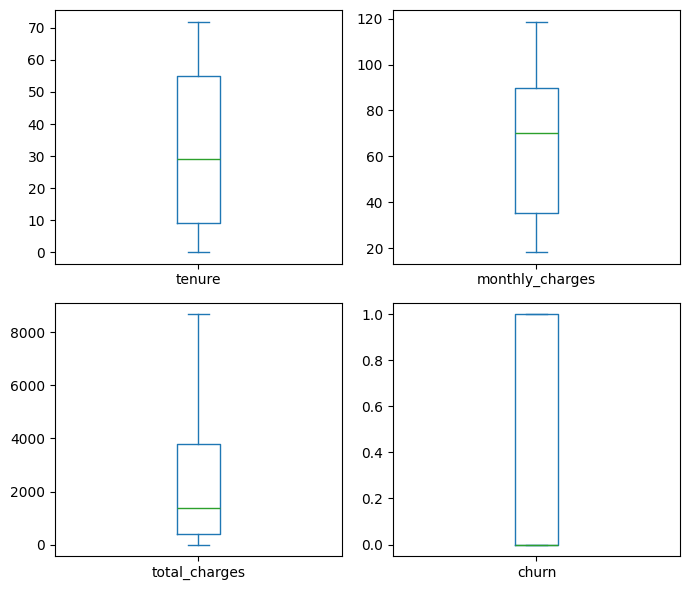

In [64]:
df.plot(kind='box', subplots=True, layout=(2, 2), figsize=(7, 6))
plt.tight_layout()
plt.show()

#### Gender:

Customer involvement by gender: